In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
from scipy.io import loadmat

mat_data = loadmat('./CTRL_AMPAR_GABAAR_BLOCKED_FIRINGS_.mat')

In [3]:
mat_data['CTRL_firings'].shape

(267028, 2)

In [4]:
data = mat_data['CTRL_firings']

In [5]:
spikes = data.T[0]
spikes = np.round(spikes).astype('int')
labels = data.T[1].astype('int')

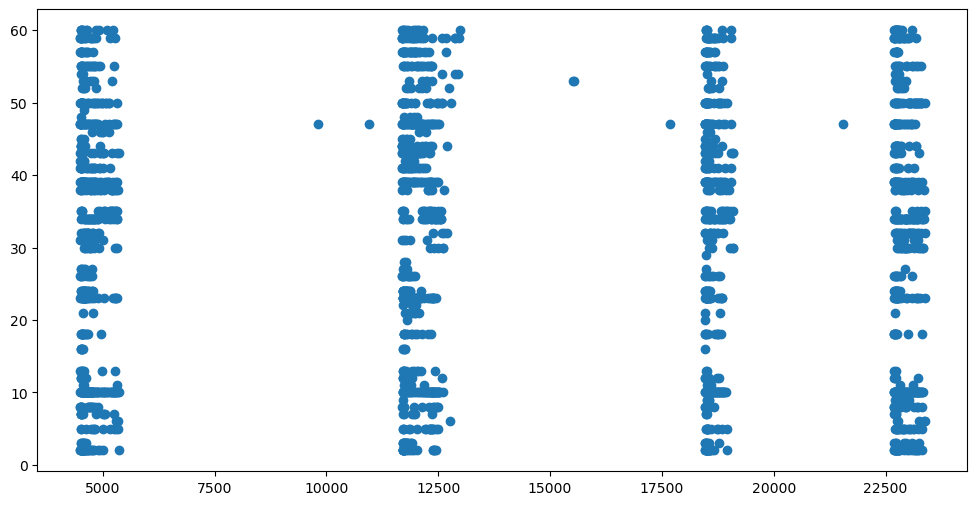

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(spikes[spikes<28000],labels[spikes<28000])
plt.show()

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [00:33<00:00,  1.80it/s]


Plotting...


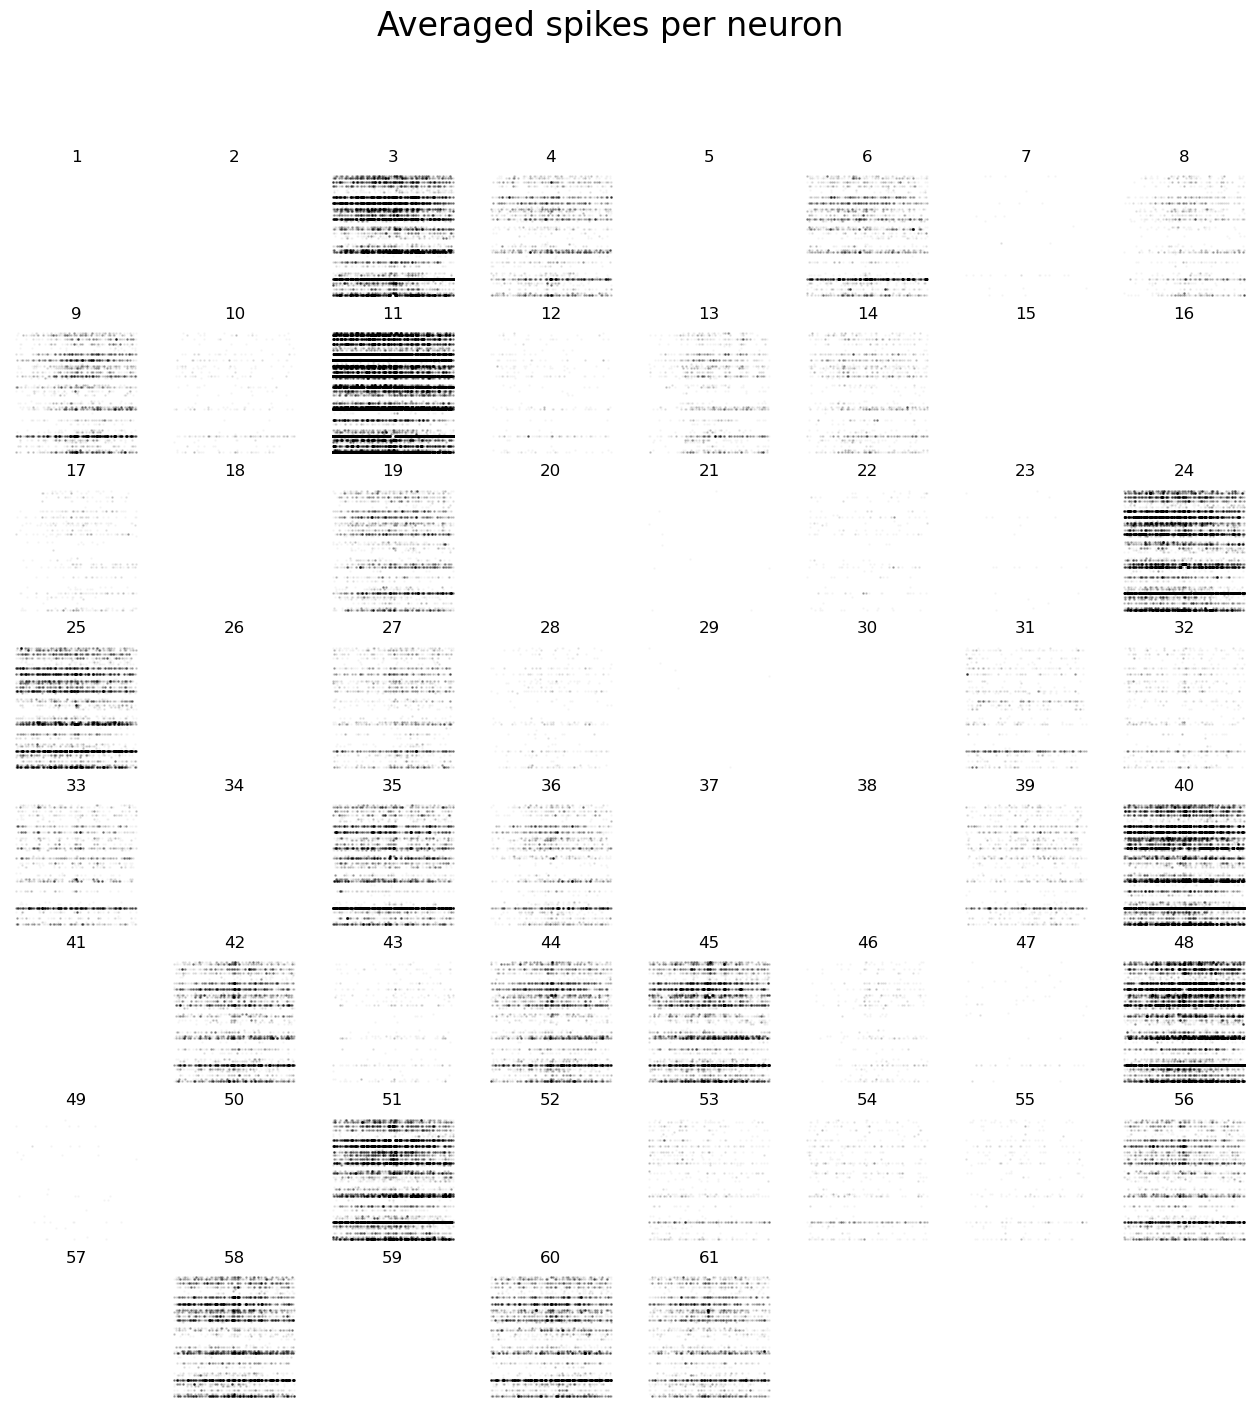

In [16]:
T_labels, N_labels = spikes[spikes<28000],labels[spikes<28000]
import neighborhood
neighborhood.plot_random(T_labels,N_labels.astype('int'),alpha=0.01)

In [25]:
np.max(N_labels)

60

In [135]:
int(np.ceil(max(subset[0])))

99816

In [136]:
np.min(neurons)

2

In [137]:
N=int(np.max(neurons))+1
D=50
T=int(np.ceil(max(subset[0]))+D)
A_sparse = (subset[1], subset[0])

In [138]:
A_dense = np.zeros((N,T))
A_dense.shape

(61, 99866)

In [139]:
for n in neurons:
    for spike in spikes[neurons==n]:
        A_dense[int(n),int(spike)] = 1

In [140]:
from tqdm import tqdm


In [141]:
'''
Post-processing and clustering
'''

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in tqdm(range(N)):
    windows_n = windows[N_labels==n]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                x[i,j] = np.sum(windows_n[i]*windows_n[j])/ min(np.sum(windows_n[i]),np.sum(windows_n[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        if not np.all(dissimilarity == 0):
            HDPs.append(linkage(dissimilarity, method='complete'))
            clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
    elif len(windows_n) == 1:
        clusters += [n*100]


clusters= np.array(clusters)

  0%|                                                                                           | 0/61 [00:00<?, ?it/s]C:\Users\miles\AppData\Local\Temp\ipykernel_18136\2888176274.py:35: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_18136\2888176274.py:36: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:43<00:00,  2.68s/it]


In [142]:
len(clusters), len(np.unique(clusters))

(7482, 5218)

well that's not a great sign...

In [143]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
    if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]
        
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''

from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(A_trunc[1])
sorted_x = A_trunc[1][sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


[4740]: 1 occurrences
[9844]: 1 occurrences
[12324]: 1 occurrences
[575]: 3 occurrences
[7076]: 1 occurrences
[9965]: 1 occurrences
[6438]: 1 occurrences
[22]: 2 occurrences
[696]: 1 occurrences
[6029]: 1 occurrences
[4717]: 1 occurrences
[6703]: 2 occurrences
[287]: 4 occurrences
[6065]: 1 occurrences
[6968]: 2 occurrences
[12301]: 1 occurrences
[552]: 3 occurrences
[9857]: 1 occurrences
[143]: 1 occurrences
[12337]: 1 occurrences
[6824]: 1 occurrences
[179]: 4 occurrences
[6415]: 1 occurrences
[3971]: 1 occurrences
[673]: 3 occurrences
[6680]: 1 occurrences
[264]: 1 occurrences
[6451]: 1 occurrences
[35]: 4 occurrences
[10472]: 1 occurrences
[6945]: 1 occurrences
[300]: 2 occurrences
[10737]: 1 occurrences
[4321]: 1 occurrences
[565]: 2 occurrences
[156]: 2 occurrences
[10593]: 1 occurrences
[7066]: 1 occurrences
[650]: 1 occurrences
[421]: 3 occurrences
[5754]: 1 occurrences
[12]: 1 occurrences
[686]: 1 occurrences
[4707]: 1 occurrences
[12026]: 1 occurrences
[277]: 4 occurrences
[9

In [144]:
all_times

[array([4542, 4809]),
 array([4519, 4820]),
 array([4599, 4838]),
 array([4515, 4936]),
 array([4630, 4778]),
 array([4536, 4850]),
 array([4578, 4837]),
 array([4605, 4833]),
 array([4577, 4772]),
 array([4501, 4773]),
 array([4690, 4844]),
 array([4519, 4812]),
 array([4518, 4868]),
 array([4509, 4982]),
 array([4497, 4932]),
 array([4626, 4991]),
 array([4739, 4772]),
 array([4596, 4792]),
 array([4509, 4896]),
 array([4723, 4813]),
 array([4516, 4793]),
 array([4620, 4782]),
 array([4653, 4936]),
 array([4513, 4826]),
 array([4544, 4862]),
 array([4726, 4795]),
 array([4639, 4812]),
 array([4564, 4895]),
 array([4516, 4861]),
 array([4582, 4837]),
 array([4616, 4984]),
 array([4613, 4781]),
 array([4521, 4864]),
 array([4536, 4794]),
 array([4501, 4961]),
 array([4719, 4871]),
 array([4505, 4938]),
 array([4610, 4852]),
 array([4725, 4876]),
 array([4733, 4873]),
 array([4523, 4886]),
 array([4757, 4797]),
 array([4583, 4885]),
 array([4609, 4852]),
 array([4693, 4896]),
 array([47

In [145]:
n = N
d = D
m = len(all_labels)
new_windows = []
all_times_ = []
pattern_num = []
pattern_template = []
for i in range(len(all_times)):
    template = np.zeros((n,d*2))
    pattern_template.append(template.copy())
    for time in all_times[i]:
        p = A_dense[:,max(time-d,0):min(time+d,A_dense.shape[1])]
        d_ = d*2 - p.shape[1]
        template[:,d_:] = p
        new_windows.append(template)
        pattern_template[-1] += template
        template = np.zeros((n,d*2))
        
    

In [150]:
pattern_template.shape

(368, 61, 100)

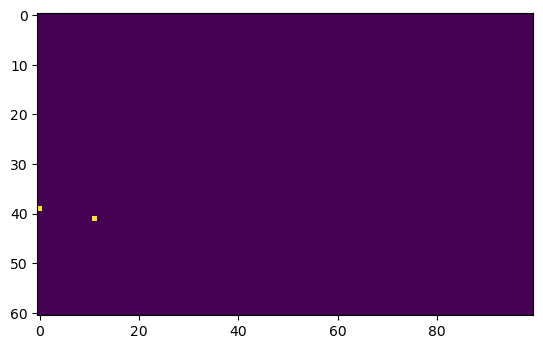

In [154]:
plt.figure()
plt.imshow(pattern_template[3])

In [147]:
for i,p in enumerate(pattern_template):
    p[p != np.max(p)] = 0
    p[p == np.max(p)] = 1
    offset = np.min(np.where(p)[1])
    pattern_template[i] = np.concatenate((p[:,offset:], p[:,:offset]),axis=1)
pattern_template = np.array(pattern_template)


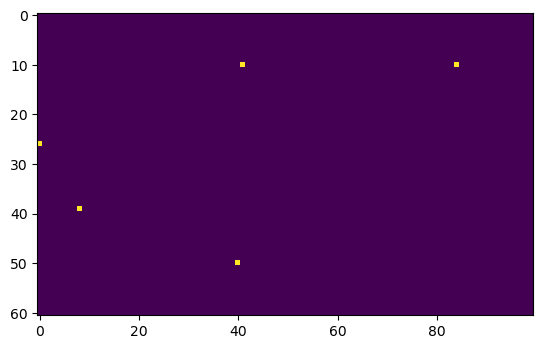

In [148]:
plt.figure()
plt.imshow(pattern_template[0])

In [149]:
from scipy.signal import correlate

matrix_x = pattern_template
matrix_y = pattern_template

# Calculate cross-correlation matrix
cross_corr_matrix = np.zeros((matrix_x.shape[0], matrix_y.shape[0]))

for x_channel_idx in range(matrix_x.shape[0]):
    for y_channel_idx in range(matrix_x.shape[0]):
        cross_corr = correlate(matrix_x[x_channel_idx,...], matrix_x[y_channel_idx,...], mode='full')
        max_corr = np.max(cross_corr)/ np.sum(matrix_x[x_channel_idx])
        cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr

dissimilarity = cross_corr_matrix-1

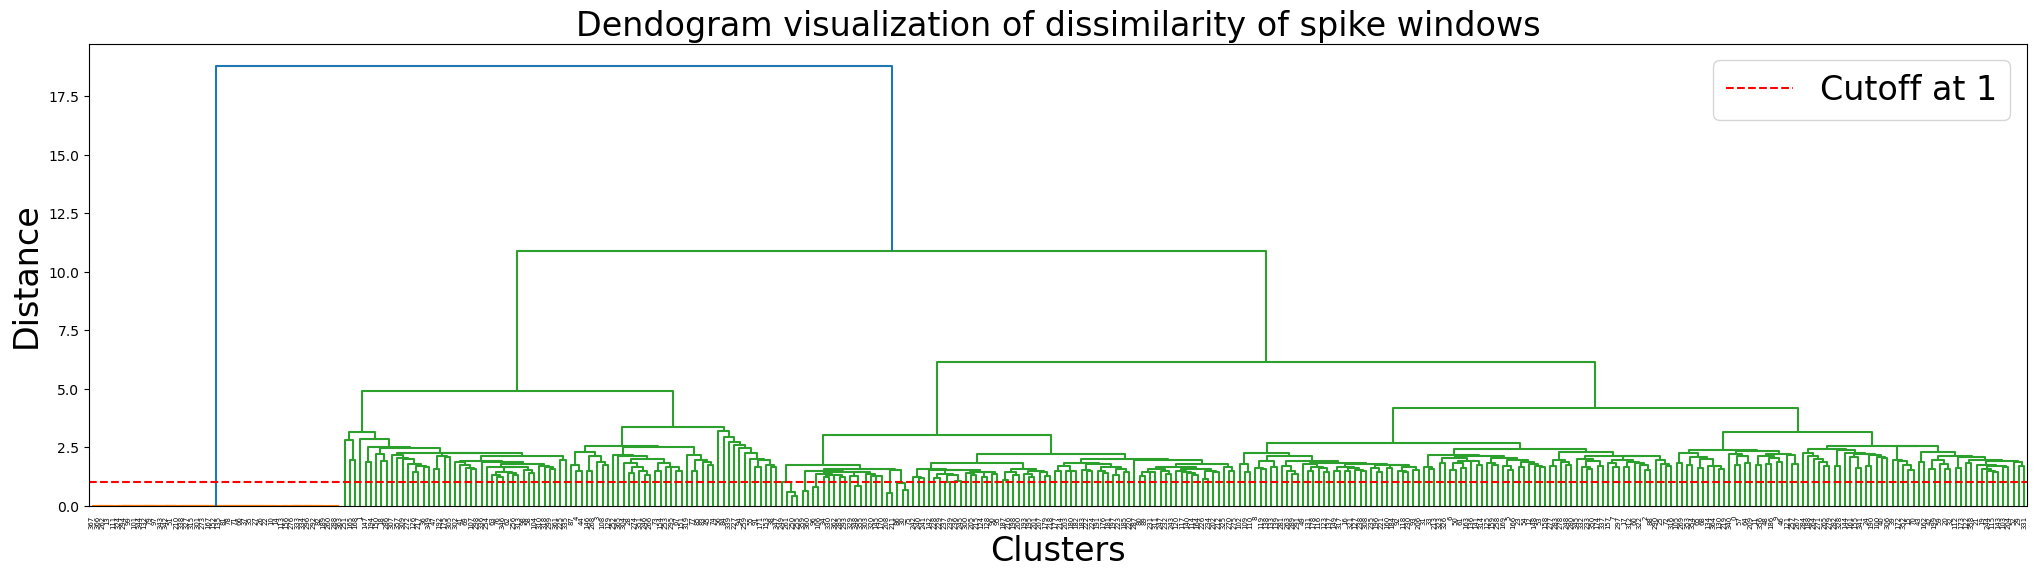

In [155]:
if len(dissimilarity) >1:
    # Create the dendrogram plot
    fig = plt.figure(figsize=(25, 6))
    HDP = linkage(dissimilarity, method='complete')
    dn = dendrogram(HDP)

    # Add a horizontal line at the cutoff value of 1
    plt.axhline(y=1, color='r', linestyle='--', label='Cutoff at 1')

    # Add labels and legend
    plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
    plt.ylabel('Distance', fontsize=24)
    plt.xlabel('Clusters', fontsize=24)
    plt.legend(fontsize=24)

    plt.show()

In [156]:
method1_labels = fcluster(HDP,cutoff, criterion='distance')

pattern_convolutions = np.zeros((pattern_template.shape[0], A_dense.shape[1]+pattern_template.shape[2]-1))
for j in tqdm(range(pattern_template.shape[0])):
    for i in range(pattern_template.shape[1]):
        pattern_convolutions[j] += correlate(A_dense[i,:], pattern_template[j,i,:], mode='full')
    pattern_convolutions[j] /= np.sum(pattern_template[j,:,:]) # normalize the convolution
    
detected_patterns = pattern_convolutions.copy()
detected_patterns[detected_patterns != 1] = 0
detected_patterns = np.sum(detected_patterns,axis=1)

method1_pattern_winners = []
for l in tqdm(np.unique(method1_labels)):
    idc = np.where(method1_labels==l)[0]
    temp = detected_patterns[method1_labels==l]
    method1_pattern_winners.append(idc[temp == max(temp)][0])
    
method1_pattern_template = pattern_template[method1_pattern_winners]
method1_pattern_template.shape

print('Method 1 detected patterns:', method1_pattern_winners)

100%|█████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 37155.55it/s]

Method 1 detected patterns: [10, 165, 168, 251, 147, 194, 18, 286, 150, 126, 217, 36, 349, 272, 309, 357, 307, 47, 192, 175, 305, 107, 298, 69, 41, 302, 76, 346, 63, 256, 313, 62, 58, 104, 98, 254, 299, 361, 318, 310, 336, 225, 335, 1, 4, 44, 87, 146, 268, 108, 129, 3, 28, 274, 246, 266, 351, 304, 73, 154, 67, 151, 295, 253, 365, 252, 77, 85, 45, 74, 83, 319, 91, 171, 38, 347, 153, 55, 259, 94, 227, 339, 84, 56, 250, 249, 359, 96, 34, 330, 285, 293, 362, 348, 329, 145, 170, 320, 303, 208, 30, 240, 241, 242, 228, 229, 237, 239, 236, 245, 205, 215, 300, 124, 128, 90, 95, 142, 187, 216, 198, 200, 195, 201, 193, 179, 218, 207, 177, 214, 180, 182, 203, 222, 224, 183, 176, 181, 191, 197, 223, 185, 220, 80, 89, 231, 311, 232, 243, 247, 114, 164, 140, 117, 120, 226, 234, 202, 212, 270, 275, 325, 287, 109, 110, 102, 119, 138, 8, 133, 139, 289, 291, 263, 281, 131, 178, 123, 137, 116, 49, 149, 317, 16, 321, 238, 308, 127, 196, 221, 235, 160, 184, 118, 230, 92, 93, 206, 33, 213, 31, 323, 326, 6, 5

In [157]:
method1_pattern_template.shape

(313, 61, 100)

In [166]:
detected_patterns.shape, detected_patterns

((368,),
 array([  2.,   5.,   2.,  20.,  11.,   2.,   2.,   2.,   2.,   2., 876.,
          2.,   2., 409., 876.,   5.,   2.,   2.,   6.,   2.,   2.,   2.,
        876.,   2.,   3.,   2., 876., 876.,  10.,   2.,   0.,   2.,   2.,
          2.,   0., 876.,   7., 876.,  34.,   4.,   3.,   2.,   2.,   2.,
          9.,  45.,   2.,   5.,   2.,   2.,   2., 156.,   2.,   2.,   2.,
         29., 109.,   2.,   2.,   2.,   2.,   2.,   3.,   6.,   2.,   2.,
        876.,  55.,   2.,   4.,   3., 876.,   2.,  13.,  21.,   0.,   2.,
         14., 876., 417.,   2., 876., 502.,  31.,  96.,  78.,   0.,  65.,
          2.,   2.,   2.,  54.,   2.,   2.,  82.,   2.,   0., 417.,   2.,
        416.,   2., 416.,   2.,   2.,   2.,   2.,   0.,   2.,  20.,   2.,
          2., 409.,   2., 165.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   4.,   2.,   2.,  12.,   2.,   2.,
        417.,   2.,   2., 876.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   0.,   5

In [170]:
promising_results = pattern_template[detected_patterns>2]

In [171]:
promising_results.shape

(130, 61, 100)

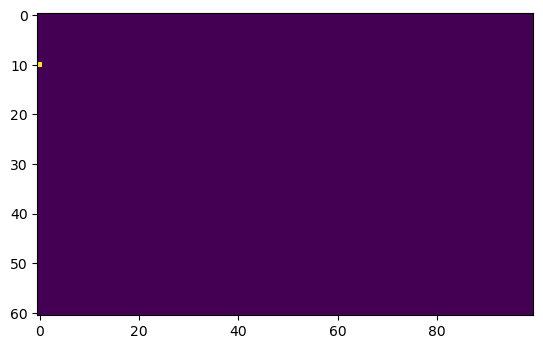

In [175]:
plt.figure()
plt.imshow(promising_results[3])